In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm; from tqdm.notebook import tqdm_notebook; tqdm_notebook.pandas()
import os
import seaborn as sns
import matplotlib.pyplot as plt; from matplotlib.backends.backend_pdf import PdfPages
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 200

# Project Details

## Parameters

In [7]:
# R1.5
samples_file = '../Phylogenetic_Tree/Release_1.5/R1.5_samples.csv'
samples_df = pd.read_csv(samples_file).rename(columns={'Order':'order','Family':'family','Genus':'genus','Species':'species'})
samples_df.loc[samples_df.DataSource=='PAFTOL','Sample'] = \
    'PAFTOL_' + samples_df.loc[samples_df.DataSource=='PAFTOL','idSequencing'].astype('str').str.zfill(6)
samples_df.loc[samples_df.DataSource!='PAFTOL','Sample'] = samples_df.loc[samples_df.DataSource!='PAFTOL','ExternalSequenceID']
samples_df = samples_df[['Sample','idSequencing','DataSource','order','family','genus','species']]
samples_df.DataSource.replace({'Annotated genome':'AG','Unannotated genome':'UG'},inplace=True)
print(samples_df.isna().sum().to_dict())
print(samples_df.shape[0],samples_df.Sample.nunique(),samples_df.groupby('DataSource').size().to_dict())
samples_df[:2]

{'Sample': 0, 'idSequencing': 0, 'DataSource': 0, 'order': 0, 'family': 0, 'genus': 0, 'species': 0}
8170 8170 {'AG': 74, 'OneKP': 686, 'PAFTOL': 6261, 'SRA': 1055, 'UG': 94}


,Sample,idSequencing,DataSource,order,family,genus,species
0,MTII,17729,OneKP,Acorales,Acoraceae,Acorus,calamus
1,PAFTOL_004799,4799,PAFTOL,Acorales,Acoraceae,Acorus,gramineus


In [3]:
# samples_file = 'OneKP/OneKP_samples.csv'
# samples_df = pd.read_csv(samples_file)

In [8]:
barcode_tests_file = 'Barcode_DB/Barcode_Tests.csv'
taxo_ranks=['genus','family']
min_test = 1
min_test_invalid = 2
max_rank = 1

In [9]:
db_folder = os.path.split(barcode_tests_file)[0] +'/'
wdir = os.path.split(samples_file)[0] +'/'
genes_df = pd.read_csv(barcode_tests_file)
print(db_folder,wdir)

Barcode_DB/ ../Phylogenetic_Tree/Release_1.5/


In [10]:
# Load all results
list_ = []
for idx, row in tqdm(samples_df.iterrows(),total=samples_df.shape[0]):
    path_sr = row.DataSource + '/Barcode_Validation/BV_' + row.Sample + '.csv'
    if os.path.exists(path_sr):
        samples_df.loc[idx,'Validation_file'] = True
        sample_validation = pd.read_csv(path_sr); sample_validation.insert(loc=0, column='Sample', value=row.Sample)
        list_.append(sample_validation)  
    else:
        samples_df.loc[idx,'Validation_file'] = False
results_df = pd.concat(list_,ignore_index=True)
print((samples_df.Validation_file==False).sum(),'barcode validation files missing:',
      list(samples_df[samples_df.Validation_file==False].Sample))
results_df.to_csv(wdir + 'All_barcode_validation_data.csv',index=False)

100%|█████████████████████████████████████████████████████████████████████████████| 8170/8170 [00:58<00:00, 140.72it/s]


140 barcode validation files missing: ['PAFTOL_006679', 'PAFTOL_008613', 'PAFTOL_006696', 'PAFTOL_006712', 'PAFTOL_006729', 'PRJNA212863', 'PRJNA268187', 'PAFTOL_005428', 'PAFTOL_007880', 'PAFTOL_004834', 'PAFTOL_006072', 'PAFTOL_005300', 'PAFTOL_005298', 'PAFTOL_008353', 'PAFTOL_006165', 'PAFTOL_006134', 'PAFTOL_008359', 'PAFTOL_016691', 'PAFTOL_006356', 'PAFTOL_006390', 'PAFTOL_006382', 'PAFTOL_016729', 'PRJNA192198', 'PRJNA238069', 'PRJNA345532', 'PRJNA10719', 'PRJNA41137', 'PRJEB12914', 'PRJEB5043', 'PRJNA217459', 'PRJNA59981', 'PRJNA231618', 'PRJNA13878', 'PRJNA73205', 'PRJNA20267', 'PRJNA41497', 'PRJNA325593', 'PAFTOL_018867', 'PRJNA33619', 'PAFTOL_011077', 'PRJDB3383', 'PRJNA391506', 'PAFTOL_012465', 'PAFTOL_012455', 'PAFTOL_012135', 'PRJNA482671', 'PRJNA72815', 'PRJNA175619', 'PRJNA19861', 'PAFTOL_007779', 'PRJNA299755', 'PRJNA10791', 'PRJNA41439', 'GCA003013575v1', 'PRJNA514254', 'PRJEB9186', 'PRJNA261643', 'PRJNA243847', 'PAFTOL_005233', 'PRJEB4211', 'PAFTOL_007877', 'PRJNA18

# Results Report

In [11]:
results_df = pd.read_csv(wdir + 'All_barcode_validation_data.csv')
print(results_df.shape[0],results_df.Sample.nunique(),results_df.Test.nunique())
results_df[:2]

96360 8030 6


,Sample,Test,tax_level,taxo,Nmatch,taxo_in_db,match,rank_pid,rank_bsc,pid,len,scov,qcov,best,best_pid,best_score,best_scov,best_qcov,NseqID,Blast
0,MTII,BOLD_pln_rbcLa,genus,Acorus,173.0,True,True,1.0,3.0,100.0,552.0,100.0,8.6,Acorus,100.0,1020.0,100.0,8.6,173.0,NaN
1,MTII,BOLD_pln_rbcLa,family,Acoraceae,173.0,True,True,1.0,3.0,100.0,552.0,100.0,8.6,Acoraceae,100.0,1020.0,100.0,8.6,173.0,NaN


In [12]:
# If the sample taxa is in db, has match, pass match, pass id and pass rank => Pass
results_df.loc[(results_df.taxo_in_db==True) & (results_df.Nmatch>0) & (results_df.match==True) & 
            (results_df.rank_pid<=max_rank) & (results_df.rank_bsc<=max_rank),'Validation'] = 'Pass both'
results_df.loc[(results_df.taxo_in_db==True) & (results_df.Nmatch>0) & (results_df.match==True) & 
            (results_df.rank_pid<=max_rank) & (results_df.rank_bsc>max_rank),'Validation'] = 'Pass pid'
results_df.loc[(results_df.taxo_in_db==True) & (results_df.Nmatch>0) & (results_df.match==True) & 
            (results_df.rank_pid>max_rank) & (results_df.rank_bsc<=max_rank),'Validation'] = 'Pass bitscore'

# # If the sample taxa is in db, has match but not match to the right taxa => fail_match
results_df.loc[(results_df.taxo_in_db==True) & (results_df.Nmatch>0) & (results_df.match==False),'Validation'] = 'Fail match'

# # If the sample taxa is in db, in match, pass id but fail rank => fail_rank
results_df.loc[(results_df.taxo_in_db==True) & (results_df.Nmatch>0) & (results_df.match==True) & 
            (results_df.rank_pid>max_rank) & (results_df.rank_bsc>max_rank),'Validation'] = 'Fail rank'

# # If the sample taxa is not in DB => NotinDB
results_df.loc[(results_df.taxo_in_db==False),'Validation'] = 'Not in DB'
# data_df.loc[(indb==False),Vvar] = 'NotinDB'
# # If the sample taxa is in DB but has no blast => NoBlast
results_df.loc[(results_df.taxo_in_db.isna()) & (results_df.Nmatch==0),'Validation'] = 'No Blast match'
results_df.loc[(results_df.taxo_in_db==True) & (results_df.Nmatch==0),'Validation'] = 'No Blast match'

print(results_df.Validation.isna().sum(),'NA')

6012 NA


In [38]:
results_df[(results_df.Validation.isna()) & (results_df.tax_level=='family')][:12]

,Sample,Test,tax_level,taxo,Nmatch,taxo_in_db,match,rank_pid,rank_bsc,pid,...,scov,qcov,best,best_pid,best_score,best_scov,best_qcov,NseqID,Blast,Validation
97,PAFTOL_006680,BOLD_pln_rbcLa,family,Araceae,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
99,PAFTOL_006680,BOLD_pln_matK,family,Araceae,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
101,PAFTOL_006680,NCBI_pln_trnL,family,Araceae,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
103,PAFTOL_006680,NCBI_pln_trnH,family,Araceae,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
107,PAFTOL_006680,NCBI_pln_plastome,family,Araceae,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
109,PAFTOL_008616,BOLD_pln_rbcLa,family,Araceae,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
111,PAFTOL_008616,BOLD_pln_matK,family,Araceae,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
113,PAFTOL_008616,NCBI_pln_trnL,family,Araceae,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
115,PAFTOL_008616,NCBI_pln_trnH,family,Araceae,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
117,PAFTOL_008616,NCBI_pln_18s,family,Araceae,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN


In [13]:
stats_tests = results_df.groupby(['Test','tax_level','Validation']).size().unstack().fillna(0).reset_index()
print(stats_tests.sum(axis=1).to_dict())
stats_tests

{0: 7336, 1: 7336, 2: 7335, 3: 7335, 4: 7831, 5: 7831, 6: 7949, 7: 7949, 8: 7389, 9: 7389, 10: 7334, 11: 7334}


Validation,Test,tax_level,Fail match,Fail rank,No Blast match,Not in DB,Pass bitscore,Pass both,Pass pid
0,BOLD_pln_matK,family,69,13,5154,17,3,911,1169
1,BOLD_pln_matK,genus,322,104,4844,829,16,573,648
2,BOLD_pln_rbcLa,family,109,46,4538,161,2,345,2134
3,BOLD_pln_rbcLa,genus,68,131,3886,2221,2,157,870
4,NCBI_pln_18s,family,141,369,2010,170,87,2538,2516
5,NCBI_pln_18s,genus,175,180,1148,5131,16,494,687
6,NCBI_pln_plastome,family,130,471,1249,498,45,1142,4414
7,NCBI_pln_plastome,genus,43,160,919,5054,23,391,1359
8,NCBI_pln_trnH,family,344,14,5827,381,9,498,316
9,NCBI_pln_trnH,genus,132,38,3183,3694,7,225,110


In [14]:
pp = PdfPages(wdir + wdir.split('/')[-2] + '_Barcoding_Validation.pdf')

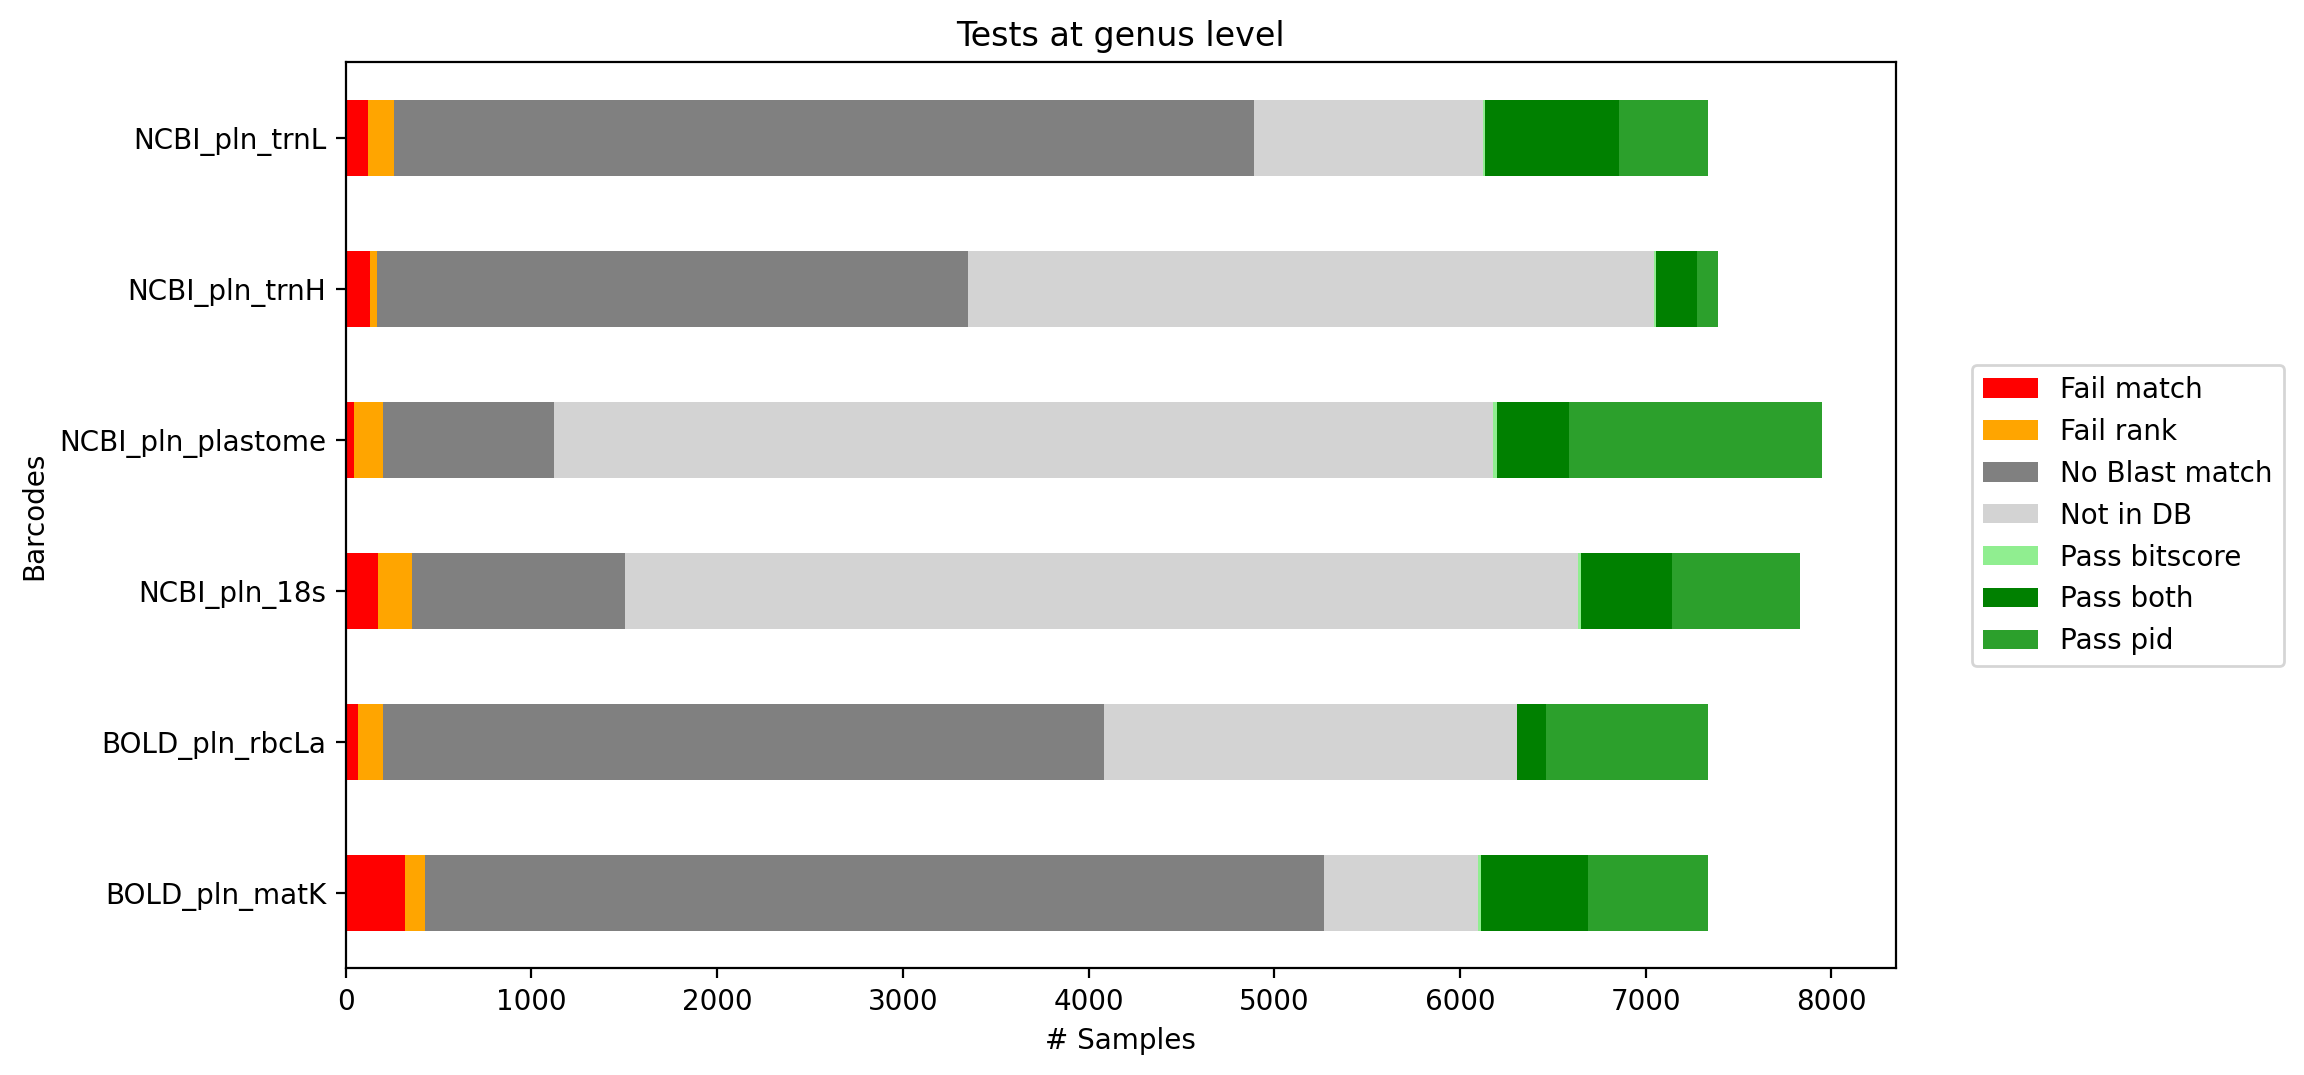

In [15]:
ax = stats_tests[stats_tests['tax_level']=='genus'].set_index(['Test']).plot.barh(stacked=True,
        color=['r', 'orange', 'grey', 'lightgrey', 'LightGreen', 'green', '#2CA02C', ])
ax.set_title('Tests at genus level')
ax.set_ylabel('Barcodes')
ax.set_xlabel('# Samples')
ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left");
pp.savefig()

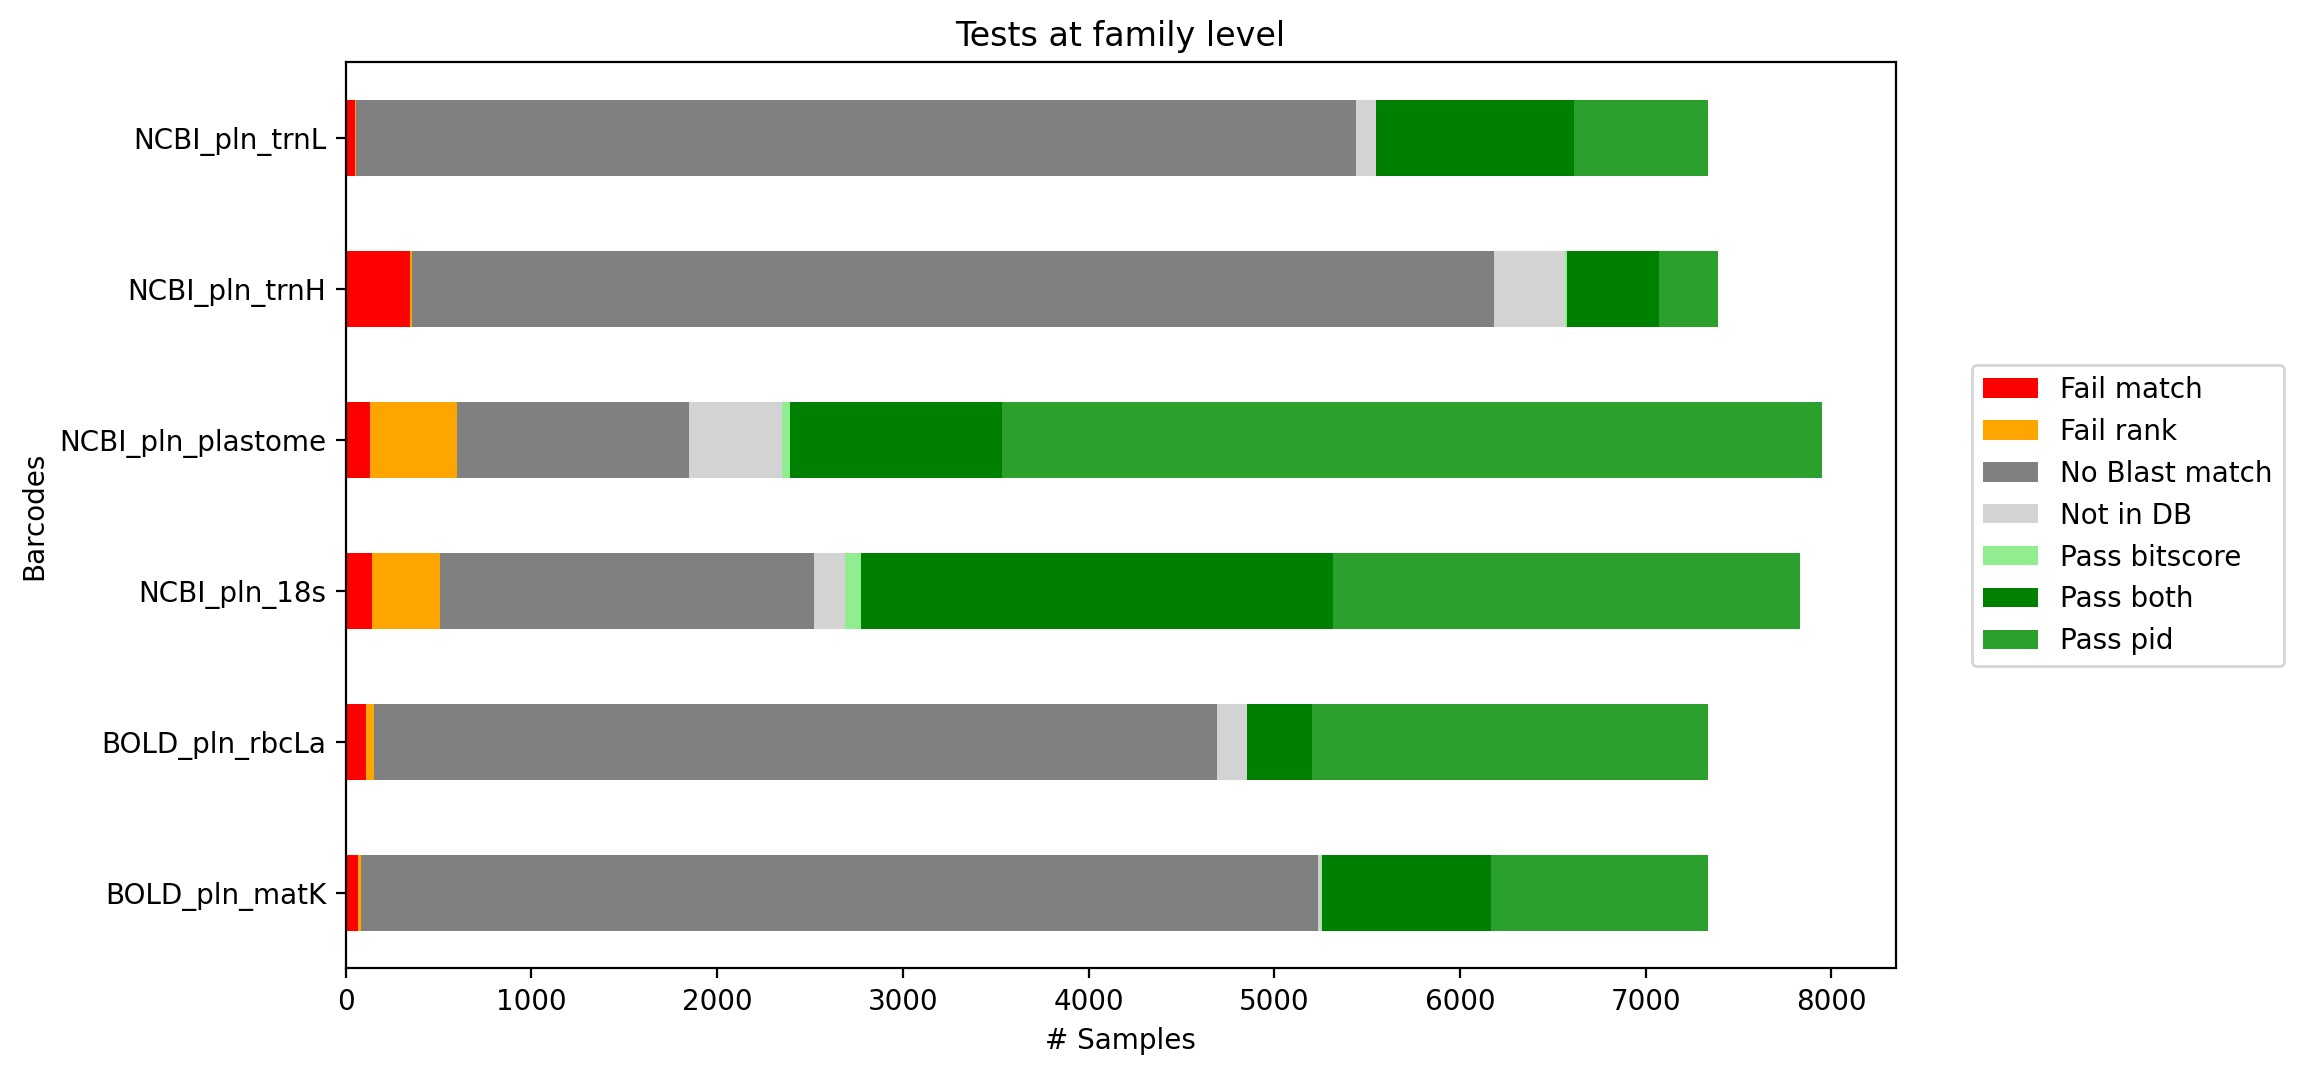

In [16]:
ax = stats_tests[stats_tests['tax_level']=='family'].set_index(['Test']).plot.barh(stacked=True,
        color=['r', 'orange', 'grey', 'lightgrey', 'LightGreen', 'green', '#2CA02C', ])
ax.set_title('Tests at family level')
ax.set_ylabel('Barcodes')
ax.set_xlabel('# Samples')
ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left");
pp.savefig()

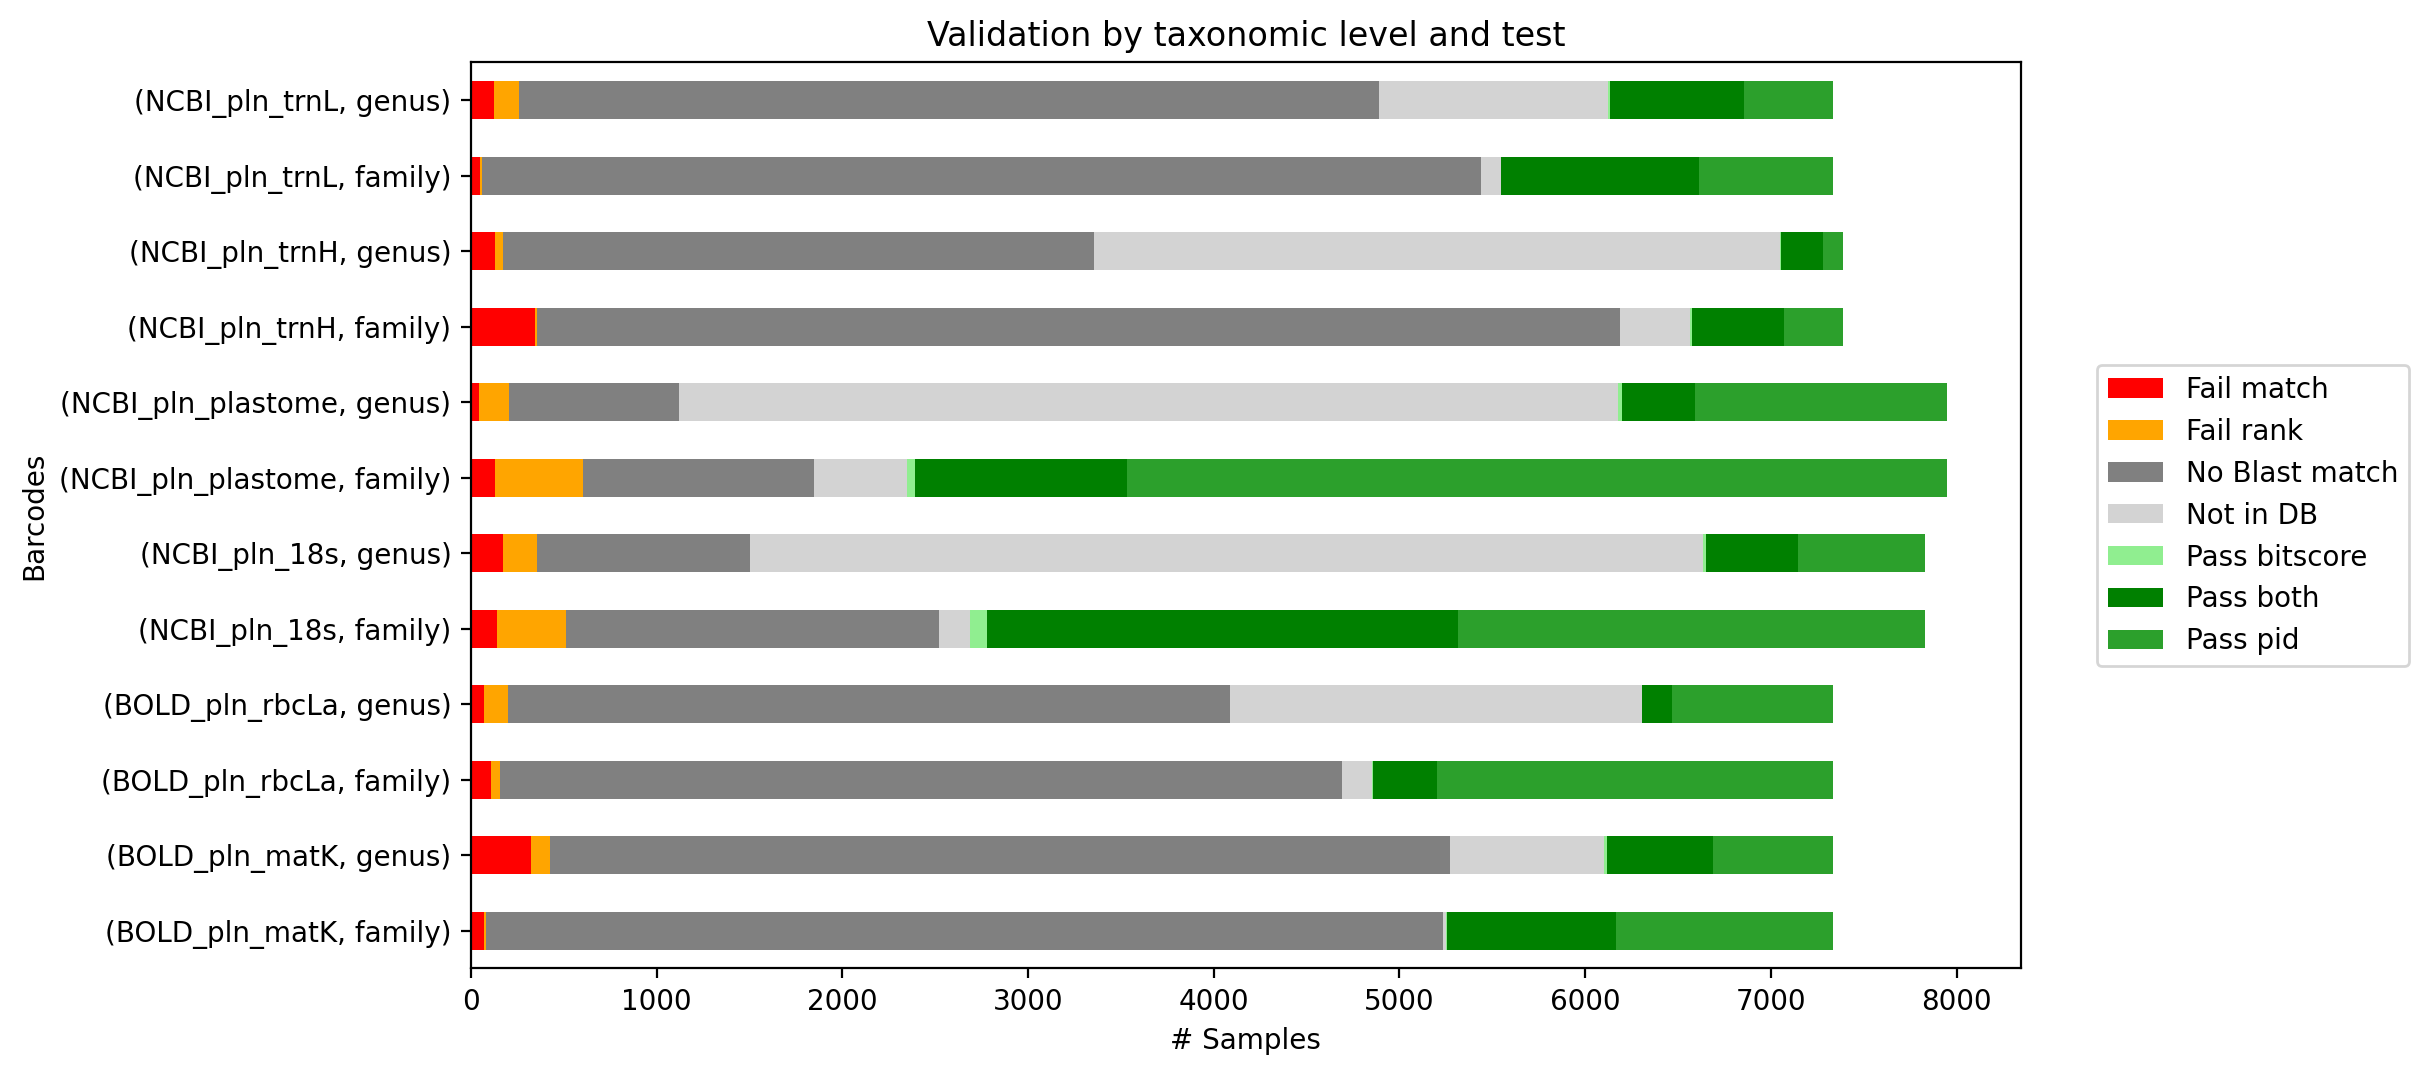

In [17]:
ax = stats_tests.set_index(['Test','tax_level']).plot.barh(stacked=True,
        color=['r', 'orange', 'grey', 'lightgrey', 'LightGreen', 'green', '#2CA02C', ])
ax.set_title('Validation by taxonomic level and test')
ax.set_ylabel('Barcodes')
ax.set_xlabel('# Samples')
ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left");
pp.savefig()

In [18]:
samples_results = samples_df.copy()
pass_cat=['Pass both','Pass pid','Pass bitscore']
fail_cat = ['Fail rank','Fail match']

### Count tests
# by family
test_count = results_df[(results_df.tax_level=='family') & (results_df.Validation.isin(pass_cat + fail_cat))].groupby('Sample').size()\
            .to_frame().reset_index().rename(columns={0:'NVfam'})
samples_results = pd.merge(samples_results,test_count,how='left')
samples_results['NVfam'] = samples_results['NVfam'].fillna(0).astype(int)
# by genus
test_count = results_df[(results_df.tax_level=='genus') & (results_df.Validation.isin(pass_cat + fail_cat))].groupby('Sample').size()\
            .to_frame().reset_index().rename(columns={0:'NVgen'})
samples_results = pd.merge(samples_results,test_count,how='left')
samples_results['NVgen'] = samples_results['NVgen'].fillna(0).astype(int)

### Passed tests
# by family
test_count = results_df[(results_df.tax_level=='family') & (results_df.Validation.isin(pass_cat))].groupby('Sample').size()\
            .to_frame().reset_index().rename(columns={0:'VATfam'})
samples_results = pd.merge(samples_results,test_count,how='left')
samples_results['VATfam'] = samples_results['VATfam'].fillna(0).astype(int)
# by genus
test_count = results_df[(results_df.tax_level=='genus') & (results_df.Validation.isin(pass_cat))].groupby('Sample').size()\
            .to_frame().reset_index().rename(columns={0:'VATgen'})
samples_results = pd.merge(samples_results,test_count,how='left')
samples_results['VATgen'] = samples_results['VATgen'].fillna(0).astype(int)

samples_results['Vfam_pc']=round(samples_results['VATfam']/samples_results['NVfam']*100,0)
samples_results['Vgen_pc']=round(samples_results['VATgen']/samples_results['NVgen']*100,0)

### Best matching taxo for failed tests
# by family 
wrong_df = results_df[(results_df.tax_level=='family') & (results_df.Validation.isin(fail_cat))]
wrong_df = wrong_df.groupby(['Sample','best']).size().sort_values(ascending=False).to_frame().reset_index()\
        .rename(columns={'best':'best matching family',0:'N best family'}).groupby('Sample').head(1)
samples_results = pd.merge(samples_results, wrong_df, how='left', on='Sample')
# by genus 
wrong_df = results_df[(results_df.tax_level=='genus') & (results_df.Validation.isin(fail_cat))]
wrong_df = wrong_df.groupby(['Sample','best']).size().sort_values(ascending=False).to_frame().reset_index()\
        .rename(columns={'best':'best matching genus',0:'N best genus'}).groupby('Sample').head(1)
samples_results = pd.merge(samples_results, wrong_df, how='left', on='Sample')

print(samples_results.shape[0],samples_results.Sample.nunique())
samples_results[:2]

8170 8170


,Sample,idSequencing,DataSource,order,family,genus,species,Validation_file,NVfam,NVgen,VATfam,VATgen,Vfam_pc,Vgen_pc,best matching family,N best family,best matching genus,N best genus
0,MTII,17729,OneKP,Acorales,Acoraceae,Acorus,calamus,True,5,5,5,5,100.0,100.0,NaN,NaN,NaN,NaN
1,PAFTOL_004799,4799,PAFTOL,Acorales,Acoraceae,Acorus,gramineus,True,5,5,5,5,100.0,100.0,NaN,NaN,NaN,NaN


In [19]:
samples_results.loc[samples_results.VATfam>=min_test,'Validation'] = 'Confirmed'
samples_results.loc[samples_results['N best family']>=min_test_invalid,'Validation'] = 'Rejected'
samples_results.loc[(samples_results.Vfam_pc>0) & (samples_results['N best family']>=min_test_invalid),'Validation'] = 'Inconclusive'
print(samples_results.groupby(['Validation']).size().to_dict())
samples_results.Validation = samples_results.Validation.fillna('Inconclusive')
print(samples_results.groupby(['Validation']).size().to_dict())
samples_results.groupby(['DataSource','Validation']).size()

{'Confirmed': 6706, 'Inconclusive': 25, 'Rejected': 79}
{'Confirmed': 6706, 'Inconclusive': 1385, 'Rejected': 79}


DataSource  Validation  
AG          Inconclusive      74
OneKP       Confirmed        669
            Inconclusive       7
            Rejected          10
PAFTOL      Confirmed       4977
            Inconclusive    1222
            Rejected          62
SRA         Confirmed        978
            Inconclusive      73
            Rejected           4
UG          Confirmed         82
            Inconclusive       9
            Rejected           3
dtype: int64

In [20]:
samples_results.loc[samples_results.VATgen>=min_test,'Validation_genus'] = 'Confirmed'
samples_results.loc[samples_results['N best genus']>=min_test_invalid,'Validation_genus'] = 'Rejected'
samples_results.loc[(samples_results.Vgen_pc>0) & (samples_results['N best genus']>=min_test_invalid),'Validation_genus'] = 'Inconclusive'
print(samples_results.groupby(['Validation_genus']).size().to_dict())
samples_results.Validation_genus = samples_results.Validation_genus.fillna('Inconclusive')
print(samples_results.groupby(['Validation_genus']).size().to_dict())
samples_results.groupby(['DataSource','Validation_genus']).size()

{'Confirmed': 3248, 'Inconclusive': 22, 'Rejected': 58}
{'Confirmed': 3248, 'Inconclusive': 4864, 'Rejected': 58}


DataSource  Validation_genus
AG          Inconclusive          74
OneKP       Confirmed            635
            Inconclusive          41
            Rejected              10
PAFTOL      Confirmed           1882
            Inconclusive        4340
            Rejected              39
SRA         Confirmed            663
            Inconclusive         386
            Rejected               6
UG          Confirmed             68
            Inconclusive          23
            Rejected               3
dtype: int64

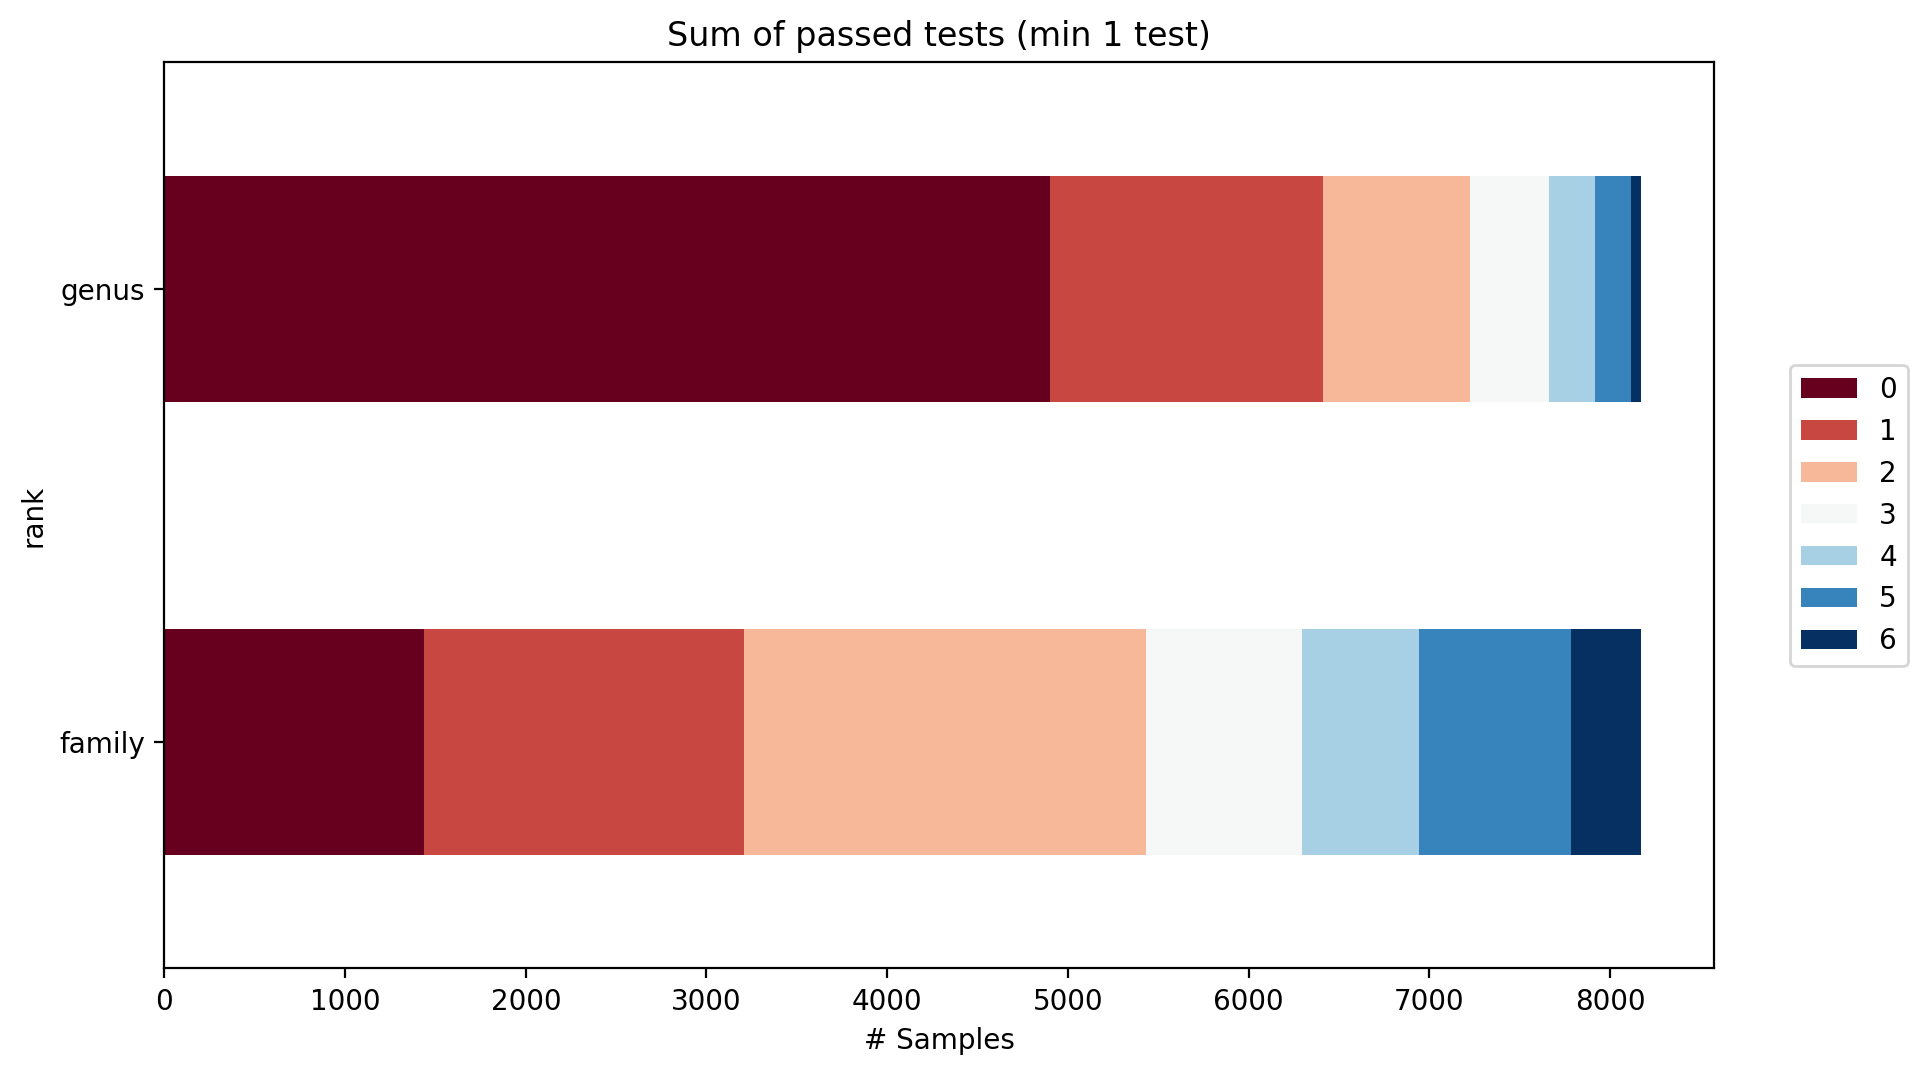

In [21]:
tmp = samples_results.groupby('VATfam').size().to_frame().reset_index().rename(columns={'VATfam':'Valid',
    0:'count'}); tmp['rank']='family'; 
fam_v=tmp.pivot(index='rank', columns='Valid', values='count').reset_index()
tmp = samples_results.groupby('VATgen').size().to_frame().reset_index().rename(columns={'VATgen':'Valid',
    0:'count'}); tmp['rank']='genus'; 
gen_v=tmp.pivot(index='rank', columns='Valid', values='count').reset_index()
all_val=pd.concat([fam_v, gen_v])
ax2 = all_val.set_index(['rank']).plot.barh(stacked=True, colormap='RdBu');
ax2.legend(bbox_to_anchor=(1.04,0.5), loc="center left");
ax2.set_title('Sum of passed tests (min ' + str(min_test) + ' test)');
ax2.set_xlabel('# Samples');
pp.savefig()

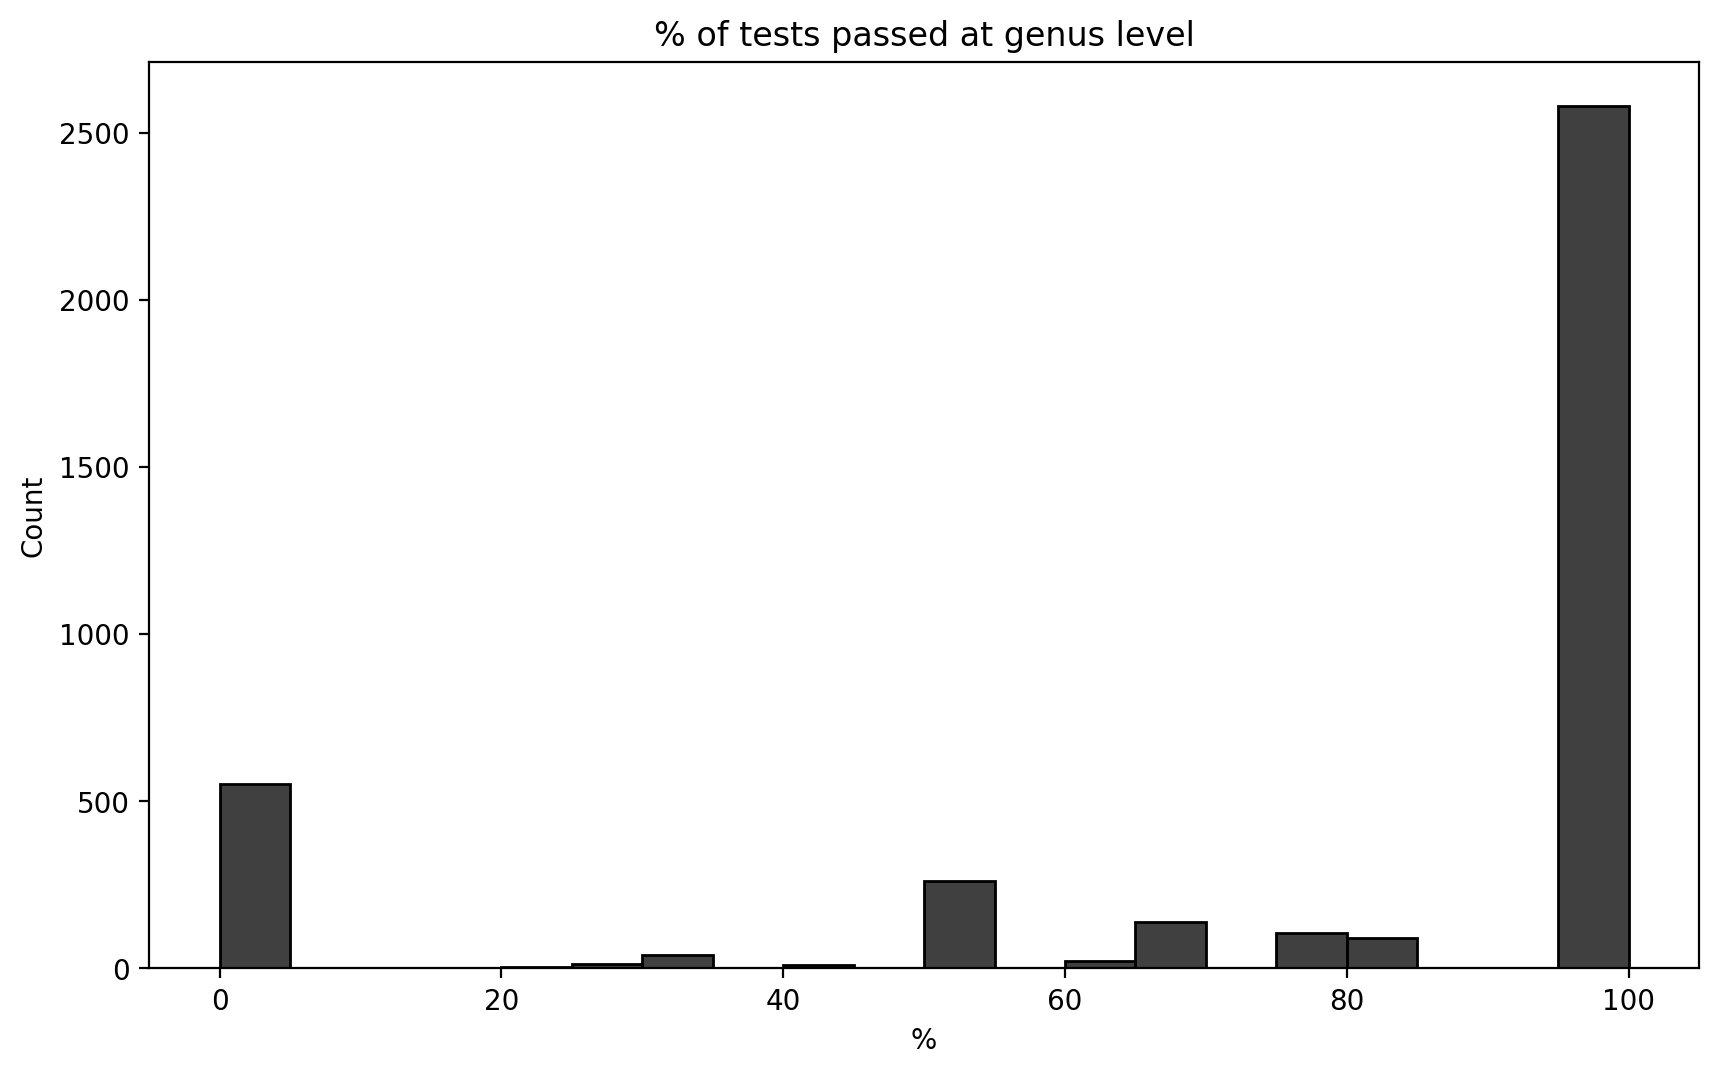

In [22]:
sns.histplot(samples_results['Vgen_pc'],kde=False, bins=20, color='k');
plt.title("% of tests passed at genus level")
plt.ylabel("Count");
plt.xlabel("%");
pp.savefig()

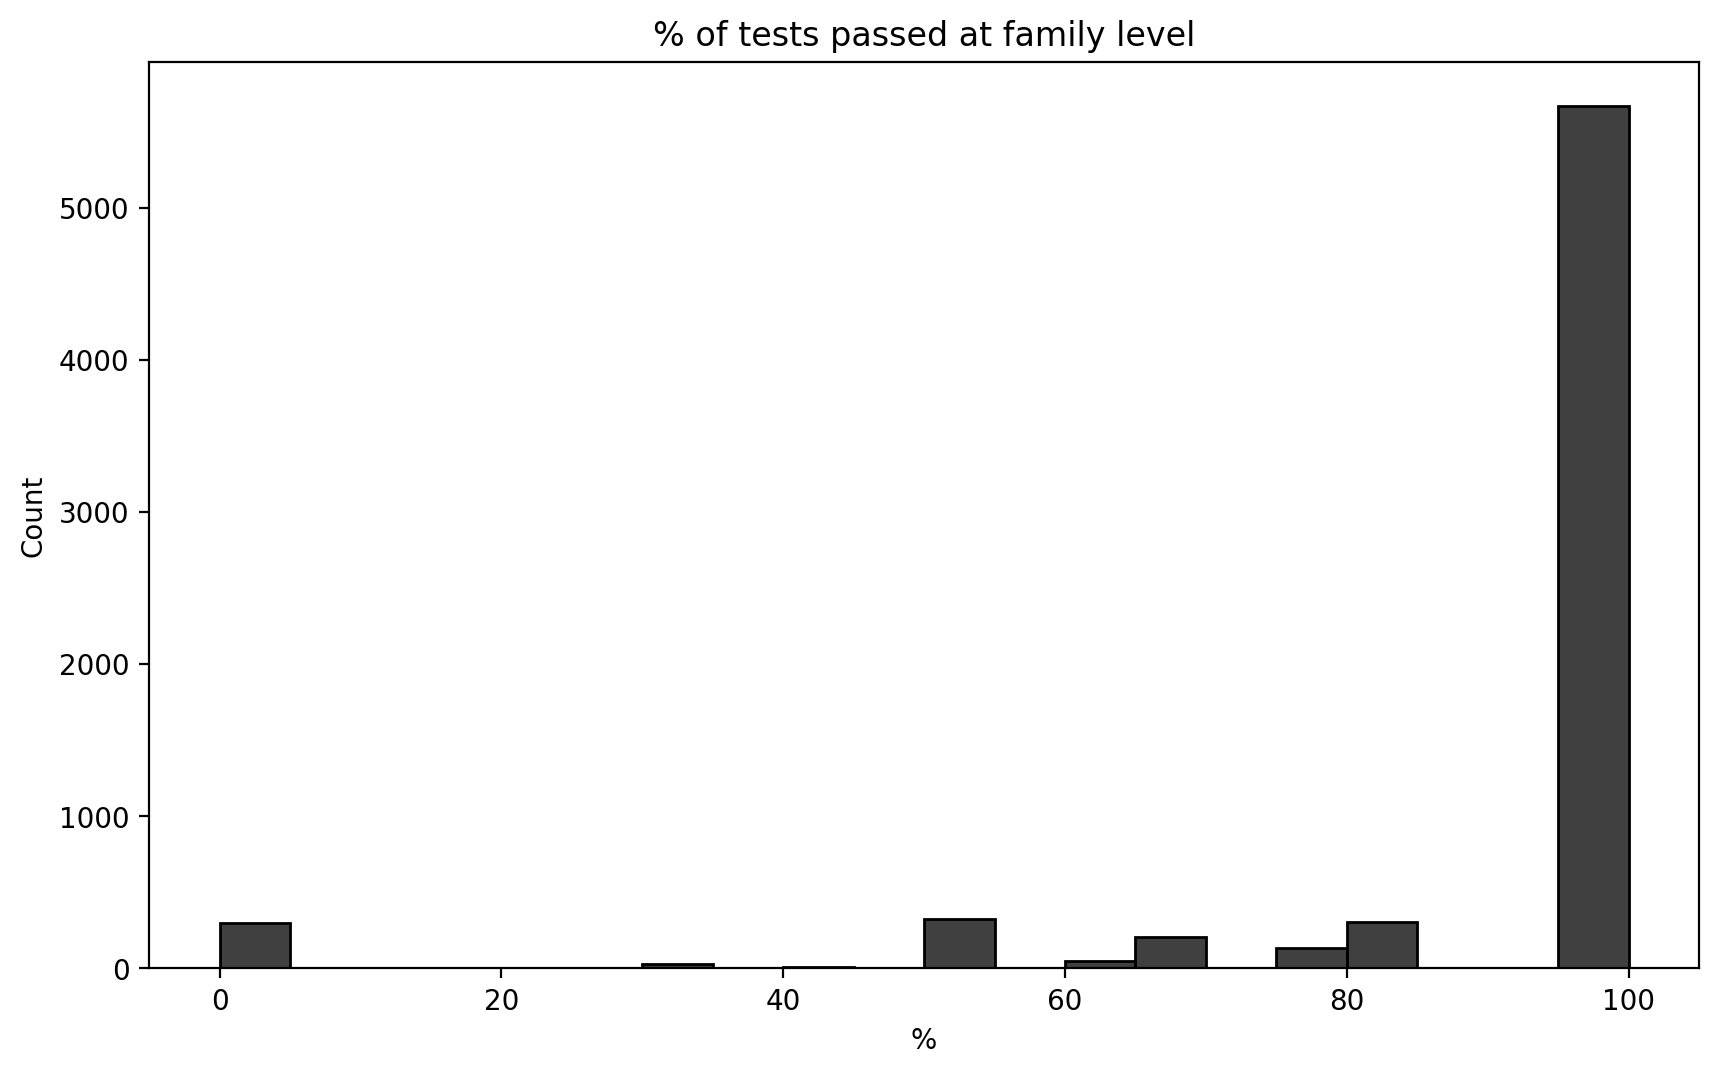

In [23]:
sns.histplot(samples_results['Vfam_pc'],kde=False, bins=20, color='k');
plt.title("% of tests passed at family level")
plt.ylabel("Count");
plt.xlabel("%");
pp.savefig()

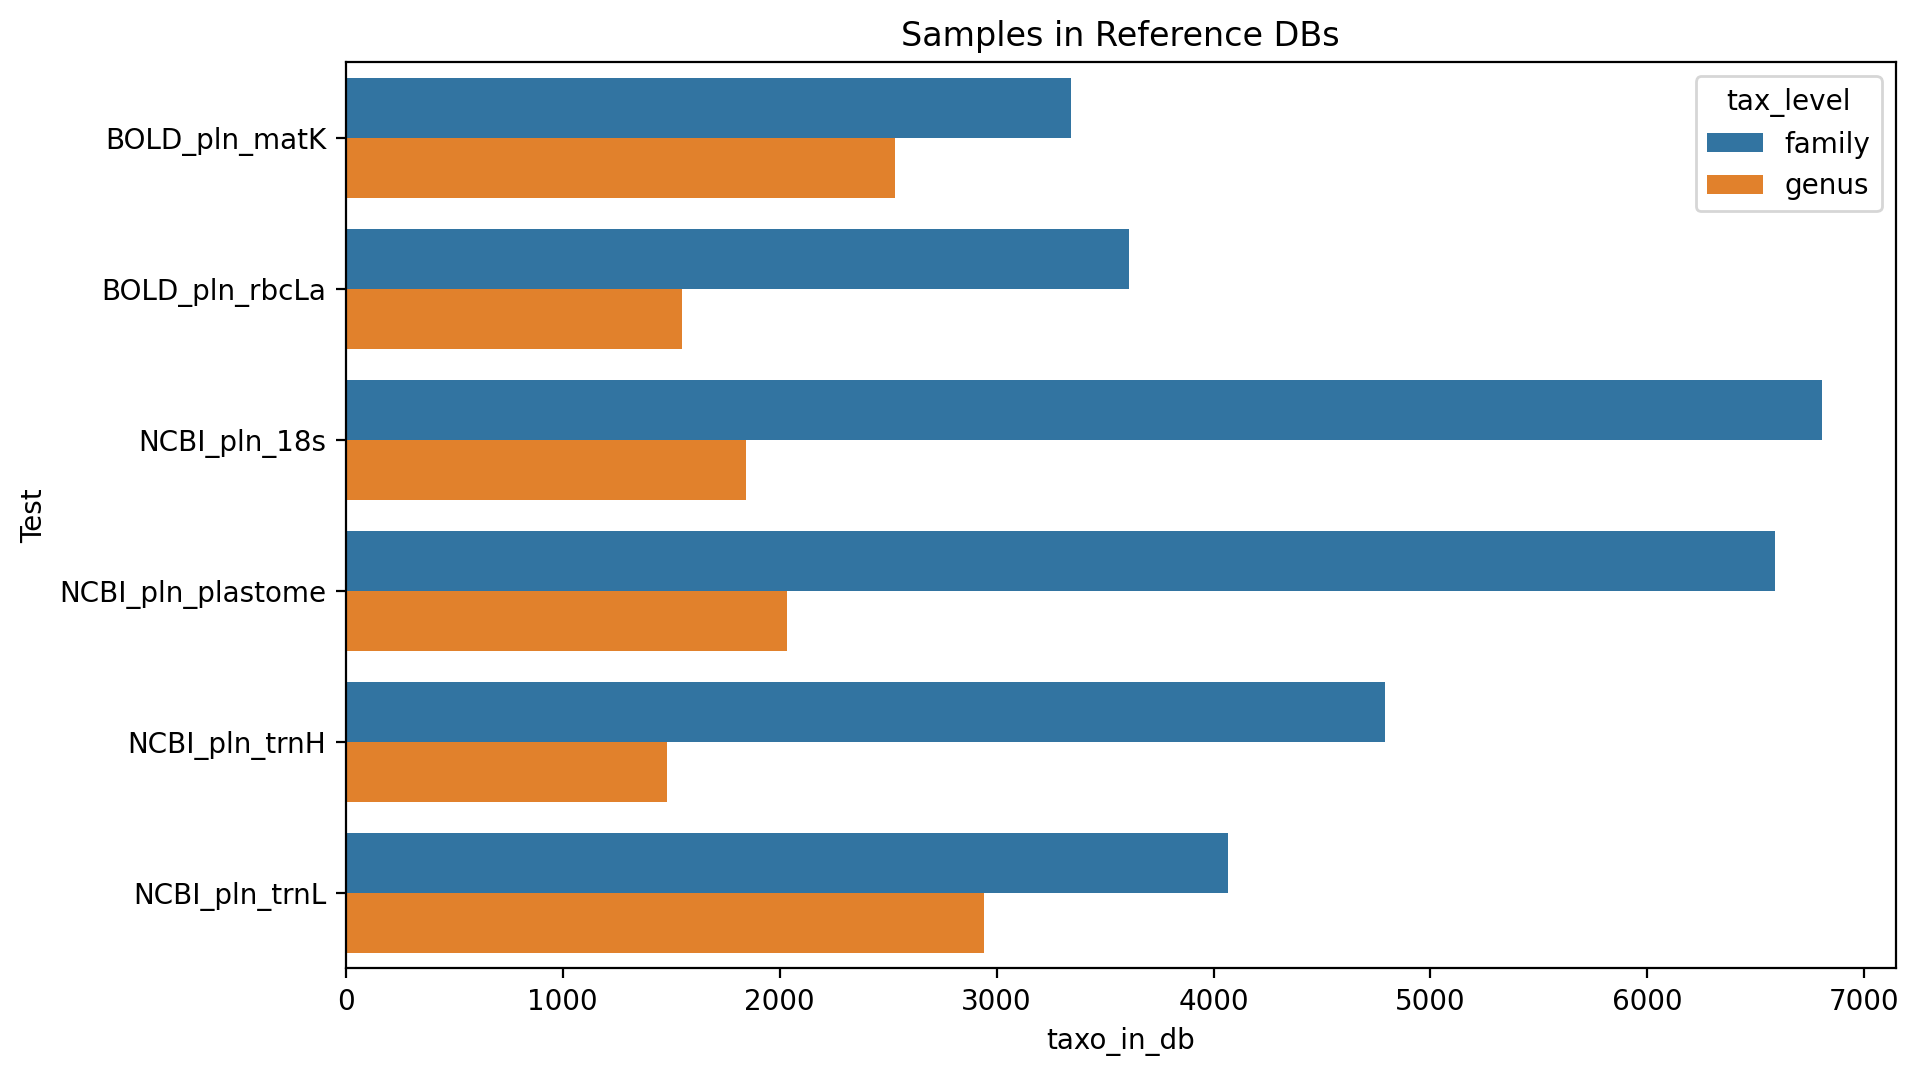

In [24]:
gene_stats = results_df.groupby(['tax_level','Test'])['taxo_in_db'].sum().to_frame().reset_index()
g = sns.barplot(data=gene_stats, 
                x="taxo_in_db", y="Test", hue="tax_level")
g.set_title("Samples in Reference DBs")
pp.savefig()

In [25]:
pp.close()

# Tables

In [26]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(wdir + wdir.split('/')[-2] + '_Barcode_Validation.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
samples_results.to_excel(writer, sheet_name='Validation_Results',index=False)
samples_results[samples_results['N best family']>=min_test_invalid].to_excel(writer, sheet_name='Wrong_family',index=False)
samples_results[samples_results['N best genus']>=min_test_invalid].to_excel(writer, sheet_name='Wrong_genus',index=False)
stats_tests.to_excel(writer, sheet_name='Test_stats',index=False)
gene_stats.to_excel(writer, sheet_name='BarcodeDB_stats',index=False)

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [27]:
import os
os.system('jupyter nbconvert --to html --output ' +
          wdir + wdir.split('/')[-2] + '_Barcode_Validation Barcode_Validation_Results_v1.5.ipynb')

0

# tmp comp


In [28]:
# R1 vs R1.5
r15 = pd.read_excel('../Phylogenetic_Tree/Release_1.5/Release_1.5_Barcode_Validation.xlsx',sheet_name='Validation_Results')
r1 = pd.read_csv('../Phylogenetic_Tree/Release_1/TableS1.csv')
print(r15.shape[0],r1.shape[0])

FileNotFoundError: [Errno 2] No such file or directory: '../Phylogenetic_Tree/Release_1/TableS1.csv'

In [ ]:
comp = pd.merge(r15[['idSequencing','Validation','DataSource','order','family','genus','species']], 
                r1[['idSequencing','Barcode_Validation','Decision']], how='inner')
print(comp.shape[0])
comp = comp[comp.DataSource!='Annotated genome']
print(comp.shape[0])
comp.groupby(['Validation','Barcode_Validation']).size().unstack().fillna(0).to_clipboard()
comp.groupby(['Validation','Barcode_Validation']).size().unstack().fillna(0)

In [ ]:
comp[(comp.Validation!=comp.Barcode_Validation)]

In [ ]:
## Relationship between validation and sum of plastom contigs length
import seaborn as sns
# Load paftol and sra organelles
getorg = pd.concat( [ pd.read_csv('../GetOrganelles/PAFTOL/PAFTOL_Organelle_Recovery.csv'),
                     pd.read_csv('../GetOrganelles/SRA/SRA_Organelle_Recovery.csv') ] )
getorg = getorg.drop(columns=['order','family','genus']).astype({'idSequencing':'int'})           
# Merge with r15
r15_ps = pd.merge(r15[r15.DataSource.isin(['PAFTOL','SRA'])],getorg, how ='left', on='idSequencing')
print(r15_ps.isna().sum().to_dict())
sns.scatterplot(x='Sum_len_pt',y='NVfam',hue='Validation',data=r15_ps);

In [ ]:
r15_ps.groupby(['Validation']).Sum_len_pt.median()

In [ ]:
r15_ps[(r15_ps.Validation=='Inconclusive') & (r15_ps.Sum_len_pt>50000)]